In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from scipy.stats import norm as ndist

# For tree-values
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Select a CRAN mirror to download from
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)  # Select the first mirror

# Install 'remotes' if it's not already installed
if not rpackages.isinstalled('remotes'):
    utils.install_packages(StrVector(('remotes',)))

import rpy2.robjects as ro

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
%load_ext rpy2.ipython

In [2]:
# Activate automatic conversion between pandas and R data frames
pandas2ri.activate()

# Import R libraries
treevalues = importr('treevalues')
rpart = importr('rpart')

def tree_values_inference(X, y, mu, sd_y, max_depth=5, level=0.1,
                          X_test=None):
    # Convert the NumPy matrix to an R matrix
    X_r = numpy2ri.py2rpy(X)
    y_r = numpy2ri.py2rpy(y)
    
    # Assign the R matrix to a variable in the R environment (optional)
    ro.globalenv['X_r'] = X_r
    ro.globalenv['y_r'] = y_r
    ro.globalenv['p'] = X.shape[1]
    
    # Construct dataset
    ro.r('data <- cbind(y_r, X_r)')
    # Set the column names to "y", "x1", "x2", ..., "x10"
    ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
    ro.r('data = data.frame(data)')
    
    # Define the rpart tree model
    tree_cmd = 'bls.tree <- rpart(y ~ ., data=data, model = TRUE, cp=0.00, maxdepth=' + str(max_depth) + ')'
    ro.r(tree_cmd)
    bls_tree = ro.r('bls.tree')
    # Plot the tree values (this will plot directly if you have a plotting backend set up)
    #ro.r('treeval.plot(bls.tree, inferenceType=0)')
    
    #ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    leaf_idx = ro.r['leaf_idx']
    
    # Get node mapping
    ro.r('idx_full <- 1:nrow(bls.tree$frame)')
    ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')
    
    len = []
    coverage = []
    len_naive = []
    coverage_naive = []
    
    for i,idx in enumerate(leaf_idx):
        # Get the branch information for a specific branch in the tree
        command = 'branch <- getBranch(bls.tree, ' + str(idx) + ')'
        ro.r(command)
        # Perform branch inference
        ro.r('result <- branchInference(bls.tree, branch, type="reg", alpha = 0.10)')
        # Get confidence intervals
        confint = ro.r('result$confint')
        len.append(confint[1] - confint[0])
    
        target_cmd = "contrast <- (bls.tree$where == mapped_idx[" + str(i+1) + "])"
        ro.r(target_cmd)
        contrast = ro.r('contrast')
        contrast = np.array(contrast)
        
        contrast = np.array(contrast * 1 / np.sum(contrast))
        
        target = contrast.dot(mu)
        coverage.append(target >= confint[0] and target <= confint[1])
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) - 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) + 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        coverage_naive.append((target >= naive_CI[0] and target <= naive_CI[1]))
        len_naive.append(naive_CI[1] - naive_CI[0])
    
    if X_test is not None:
        X_test_r = numpy2ri.py2rpy(X_test)
        ro.globalenv['X_test_r'] = X_test_r
        ro.r('pred <- predict(bls.tree, data = X_test_r)')
        pred = ro.r['pred']
    else:
        pred = None
        
    return (np.mean(coverage), np.mean(len), 
            np.mean(coverage_naive), np.mean(len_naive), pred) 

In [3]:
def generate_test(mu, sd_y):
    n = mu.shape[0]
    return mu + np.random.normal(size=(n,), scale=sd_y)

In [4]:
import seaborn as sns
def boxplots(dfs, metrics):
    # Set up the subplots: one for each metric
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    
    # Iterate over the dataframes and create a boxplot for each
    for i, (df, metric) in enumerate(zip(dfs, metrics)):
        sns.boxplot(data=df, ax=axes[i])
        axes[i].set_title(f'Boxplot for {metric}')
        axes[i].set_xlabel('Method')
        axes[i].set_ylabel('Value')
        # Add triangles for the mean values
        means = df.mean()  # Calculate mean for each method (column)
        print(metric,":\n",means.T)
        for j, mean in enumerate(means):
            axes[i].plot(j, mean, marker='^', color='red', markersize=10)  # Add a red triangle for the mean
        if metric == "Coverage":
            axes[i].set_ylim(0,1)
        elif metric == "Length":
            axes[i].set_ylim(0,100)
        elif metric == "MSE":
            axes[i].set_ylim(0,3)
    
    # Show the plots
    plt.tight_layout()
    plt.show()

In [5]:
n = 100
p = 10
X = np.random.normal(size=(n, p))
a = 1
b = 5

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd_y = 1
noise_sd = 0.5

In [6]:
X = np.random.normal(size=(n, p))

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
y = mu + np.random.normal(size=(n,), scale=sd_y)
y_test = generate_test(mu, sd_y)

In [7]:
def UV_decomposition(X, y, mu, sd_y, 
                     max_depth=5, min_prop=0, min_sample=10, min_bucket=5,
                     level=0.1, gamma=1,
                     X_test=None):
    n = X.shape[0]
    W = np.random.normal(loc=0, scale=sd_y*np.sqrt(gamma), size=(n,))
    U = y + W
    V = y - W/gamma
    sd_V = sd_y * np.sqrt(1 + 1/gamma)
    reg_tree = RegressionTree(min_samples_split=min_sample, max_depth=max_depth,
                              min_proportion=min_prop, min_bucket=min_bucket)
    reg_tree.fit(X, U, sd = 0)
    
    coverage = []
    lengths = []
    
    for node in reg_tree.terminal_nodes:
        contrast = node.membership
        
        contrast = np.array(contrast * 1 / np.sum(contrast))
        
        target = contrast.dot(mu)
        
        # Naive after tree value
        # Confidence intervals
        CI = [contrast.dot(V) - 
              np.linalg.norm(contrast) * sd_V * ndist.ppf(1 - level / 2),
              contrast.dot(V) + 
              np.linalg.norm(contrast) * sd_V * ndist.ppf(1 - level / 2)]
        coverage.append((target >= CI[0] and target <= CI[1]))
        lengths.append(CI[1] - CI[0])
        
    if X_test is not None:
        pred = reg_tree.predict(X_test)
    else:
        pred = None
        
    return coverage, lengths, pred

In [8]:
def tree_values_predict(X, y, mu, sd_y, max_depth=5, level=0.1,
                        X_test=None):
    # Convert the NumPy matrix to an R matrix
    X_r = numpy2ri.py2rpy(X)
    y_r = numpy2ri.py2rpy(y)
    
    # Assign the R matrix to a variable in the R environment (optional)
    ro.globalenv['X_r'] = X_r
    ro.globalenv['y_r'] = y_r
    ro.globalenv['p'] = X.shape[1]
    
    # Construct dataset
    ro.r('data <- cbind(y_r, X_r)')
    # Set the column names to "y", "x1", "x2", ..., "x10"
    ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
    ro.r('data = data.frame(data)')
    
    # Define the rpart tree model
    tree_cmd = ('bls.tree <- rpart(y ~ ., data=data, model = TRUE, ' + 
                'control = rpart.control(cp=0.00, minsplit = 15, minbucket = 5, maxdepth=') + str(max_depth) + '))'
    ro.r(tree_cmd)
    bls_tree = ro.r('bls.tree')
    # Plot the tree values (this will plot directly if you have a plotting backend set up)
    #ro.r('treeval.plot(bls.tree, inferenceType=0)')
    
    #ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    leaf_idx = ro.r['leaf_idx']
    
    # Get node mapping
    ro.r('idx_full <- 1:nrow(bls.tree$frame)')
    ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')
    
    terminal_sizes = []
    
    for i,idx in enumerate(leaf_idx):
        target_cmd = "contrast <- (bls.tree$where == mapped_idx[" + str(i+1) + "])"
        ro.r(target_cmd)
        contrast = ro.r('contrast')
        membership = np.array(contrast)
        terminal_sizes.append(membership.sum())
    
    if X_test is not None:
        X_test_r = numpy2ri.py2rpy(X_test)
        ro.globalenv['X_test_r'] = X_test_r
        ro.r('pred <- predict(bls.tree, data = X_test_r)')
        pred = ro.r['pred']
    else:
        pred = None
        
    return (pred, terminal_sizes) 

In [9]:
def test_MSE(n = 50, p = 5, a = 0.1, b = 0.1, 
             sd_y = 1, noise_sd_list = [0.5, 1, 2, 5], 
             start=0, end=100,
             level=0.1):
    MSE_dict = {m: [] for m in noise_sd_list + ["Tree val"]}
    min_terminal_size_dict = {m: [] for m in noise_sd_list + ["Tree val"]}
    terminal_size_sd_dict = {m: [] for m in noise_sd_list + ["Tree val"]}
    
    coverage_UV = []
    len_UV = []
    MSE_UV = []
    
    for i in range(start, end):
        print(i, "th simulation")
        #np.random.seed(i + 48105)
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        y_test = generate_test(mu, sd_y)
        
        for noise_sd in noise_sd_list:
            # Create and train the regression tree
            reg_tree = RegressionTree(min_samples_split=15, max_depth=3,
                                      min_proportion=0, min_bucket=5)
            reg_tree.fit(X, y, sd = noise_sd * sd_y)
            
            pred_test = reg_tree.predict(X)
            MSE_test = (np.mean((y_test - pred_test) ** 2))
            # Record results
            MSE_dict[noise_sd].append(MSE_test)
            terminal_sizes = [node.membership.sum() for node in reg_tree.terminal_nodes]
            min_terminal_size_dict[noise_sd].append(min(terminal_sizes))
            terminal_size_sd_dict[noise_sd].append(np.std(terminal_sizes))
        
        pred_test_treeval, tree_values_terminal_sizes\
            = tree_values_predict(X, y, mu, sd_y=sd_y, 
                                  X_test=X, max_depth=3)

        MSE_test_treeval = (np.mean((y_test - pred_test_treeval) ** 2))
        MSE_dict["Tree val"].append(MSE_test_treeval)
        min_terminal_size_dict["Tree val"].append(min(tree_values_terminal_sizes))
        terminal_size_sd_dict["Tree val"].append(np.std(tree_values_terminal_sizes))
        
        coverage, lengths, pred_UV = UV_decomposition(X, y, mu, sd_y, X_test=X,
                                                      min_prop=0, max_depth=3, 
                                                      min_sample=15, min_bucket=5)
        coverage_UV.append(np.mean(coverage))
        len_UV.append(np.mean(lengths))
        MSE_UV.append((np.mean((y_test - pred_UV) ** 2)))
        
    print("UV coverage:", np.mean(coverage_UV))
    print("UV length:", np.mean(len_UV))
    print("UV MSE:", np.mean(MSE_UV))
        
    return MSE_dict, min_terminal_size_dict, terminal_size_sd_dict

In [10]:
MSE_dict, min_terminal_size_dict, terminal_size_sd_dict\
    = test_MSE(start=0, end=200, n=200, p=10, sd_y=3, 
                    noise_sd_list=[0.5, 1, 5, 10],#[0.5, 1, 2, 5, 10, 20, 50], 
                    a=1,b=1, level=0.1)

0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation


KeyboardInterrupt: 

MSE :
 0.5         11.212429
1           11.203970
5           10.954146
10          10.673095
Tree val    11.196518
dtype: float64
Min Terminal Node Size :
 0.5         2.585
1           2.430
5           2.920
10          3.425
Tree val    2.525
dtype: float64
Terminal Node Size SD :
 0.5         27.753710
1           27.964637
5           25.107719
10          22.800039
Tree val    28.063438
dtype: float64


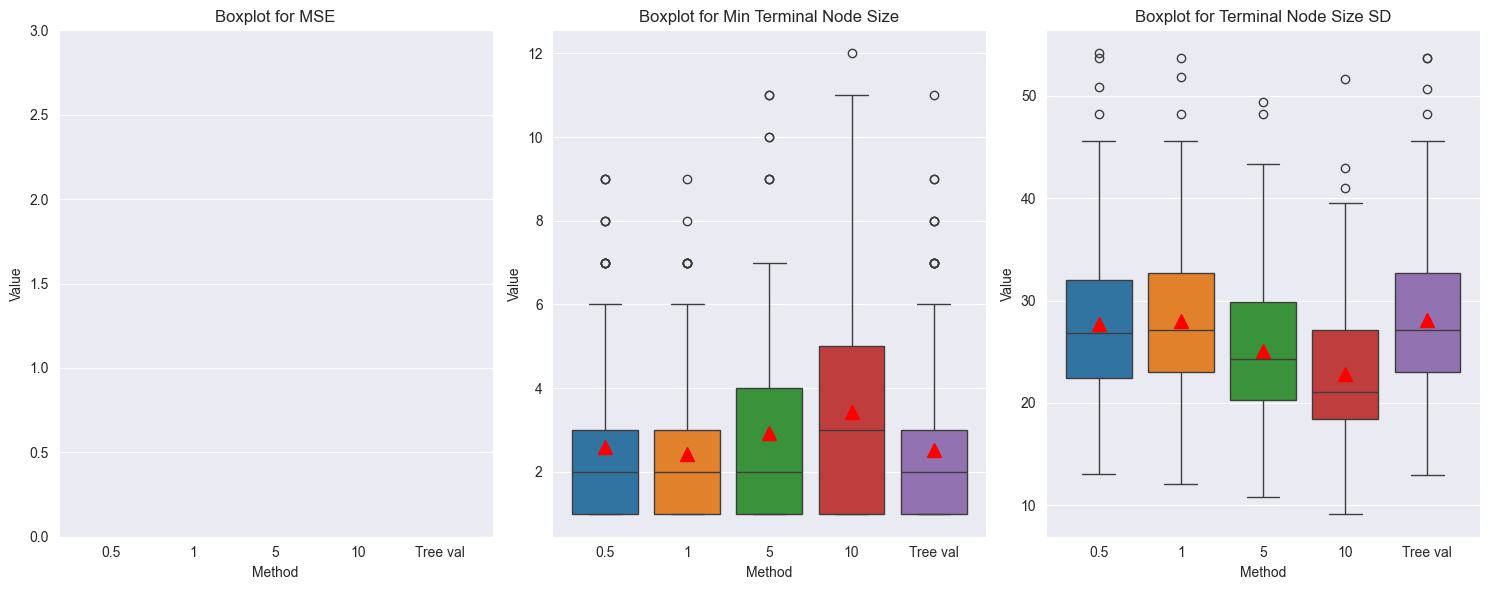

In [60]:
boxplots(dfs=[pd.DataFrame(MSE_dict), 
              pd.DataFrame(min_terminal_size_dict),
              pd.DataFrame(terminal_size_sd_dict)], 
         metrics=["MSE", "Min Terminal Node Size", "Terminal Node Size SD"])

In [14]:
df = pd.concat([pd.DataFrame(MSE_dict).mean(),
                pd.DataFrame(min_terminal_size_dict).mean(),
                pd.DataFrame(terminal_size_sd_dict).mean()], axis=1)

In [15]:
df.columns = ["MSE", "Min Terminal Node Size", "Terminal Node Size SD"]

In [16]:
print(df)

               MSE  Min Terminal Node Size  Terminal Node Size SD
0.5       1.226004                   4.680              20.566696
1         1.229484                   5.095              19.509548
2         1.209354                   5.050              18.697467
5         1.197147                   5.330              17.348051
Tree val  1.226276                   4.910              20.343045


In [133]:
# TODO: Check documentation of rpart to see what's the default configuration
# of tree-value's fitting algorithm

In [61]:
reg_tree.terminal_nodes[3].membership.sum()

np.float64(9.0)